In [12]:
from deap import base, creator, tools, algorithms
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import random

import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
import subprocess
import numpy as np

In [13]:
df_moterway = pd.read_csv('moterwayWInfo.csv')
display(df_moterway)

df_moterway['status_3_ratio_mean'] = df_moterway['status_3_ratio_mean']*df_moterway['ratios_length']*17

#sort by status_3_ratio_mean
df_moterway = df_moterway.sort_values(by='status_3_ratio_mean', ascending=True)
display(df_moterway[['Unnamed: 0','longitude', 'latitude', 'status_3_ratio_mean']])
df_moterway[['Unnamed: 0','longitude', 'latitude', 'status_3_ratio_mean']].to_csv('moterway.csv', index=False)


,Unnamed: 0.1,Unnamed: 0,slug,status_3_ratio_mean,status_3_ratio_var,latitude,longitude,ratios,ratios_length,minCapacity,maxCapacity
0,2,196,jq8xwm,0.557396,0.246763,55.723784,9.583650,[0.5573961735884274],1,50.0,50.0
1,4,214,kj9rwe,0.536461,0.119460,55.626754,12.575313,"[0.41407338597306087, 0.6588481189038551]",2,43.0,50.0
2,5,275,qk7jyq,0.512143,0.073666,55.489341,12.161393,"[0.5177782942133395, 0.4991866139902394, 0.478...",16,300.0,300.0
3,14,162,eeq85m,0.457639,0.129254,55.453194,11.789021,"[0.42083333333333334, 0.49444444444444446]",2,43.0,50.0
4,16,120,8zxw8,0.448415,0.069050,55.786395,9.667926,"[0.4848917439923864, 0.46157506542945514, 0.37...",16,150.0,150.0
...,...,...,...,...,...,...,...,...,...,...,...
111,367,158,ee8gk8,0.026240,0.013391,55.065492,9.367220,"[0.01674418604651163, 0.03697674418604651]",2,43.0,50.0
112,368,336,x697j,0.026006,0.017300,57.152389,10.161239,"[0.014331946370781322, 0.037679149329634766]",2,43.0,50.0
113,375,78,7kerez,0.023870,0.001390,55.166096,11.958106,"[0.04847481674154647, 0.003310475289666588, 0....",18,60.0,300.0
114,385,268,pz6wdm,0.016407,0.002451,56.185779,9.578401,"[0.016775396085740912, 0.0006981615080288574, ...",8,600.0,600.0


,Unnamed: 0,longitude,latitude,status_3_ratio_mean
112,336,10.161239,57.152389,0.884189
111,158,9.367220,55.065492,0.892171
110,171,9.764320,56.147603,1.176893
109,384,9.937210,57.222600,1.239010
106,351,9.766954,56.149722,1.284952
...,...,...,...,...
15,118,11.361842,55.387910,125.194001
12,308,9.716938,55.534483,128.493454
14,255,10.419778,55.352714,138.276680
2,275,12.161393,55.489341,139.302812


In [28]:
weights = {
    "traffic_weight": 0,
    "fastFoods_weight": 0,
    "hotels_weight": 0,
    "motorwayLinks_weight": 0,
    "motorways_weight": 0,
    "restaurants_weight": 0,
    "shopSupermarkets_weight": 0,
}
with open("weights_float.txt", "w") as file:
    for name, value in weights.items():
        file.write(f"{name} {float(value)}\n")

minDistance = {
    'traffic_distance': 0.1,
    'fastFoods_distance': 0.1,
    'hotels_distance': 0.1,
    'motorwayLinks_distance': 0.1,
    'motorways_distance': 0.1,
    'restaurants_distance': 0.1,
    'shopSupermarkets_distance': 0.1,
}


with open("minDistance.txt", "w") as file:
    for name, value in minDistance.items():
        file.write(f"{name} {float(value)}\n")

In [14]:
def custom_cxBlend(ind1, ind2, alpha):
    for i in range(len(ind1)):
        gamma = (1. + 2. * alpha) * random.random() - alpha
        ind1[i], ind2[i] = ind1[i] + gamma * (ind2[i] - ind1[i]), ind2[i] + gamma * (ind1[i] - ind2[i])
        ind1[i], ind2[i] = max(0, ind1[i]), max(0, ind2[i])  # Ensure non-negative
    return ind1, ind2

def custom_mutGaussian(individual, mu, sigma, indpb):
    size = len(individual)
    for i in range(size):
        if random.random() < indpb:
            individual[i] += random.gauss(mu, sigma)
            individual[i] = max(0, individual[i])  # Ensure non-negative
    return individual,


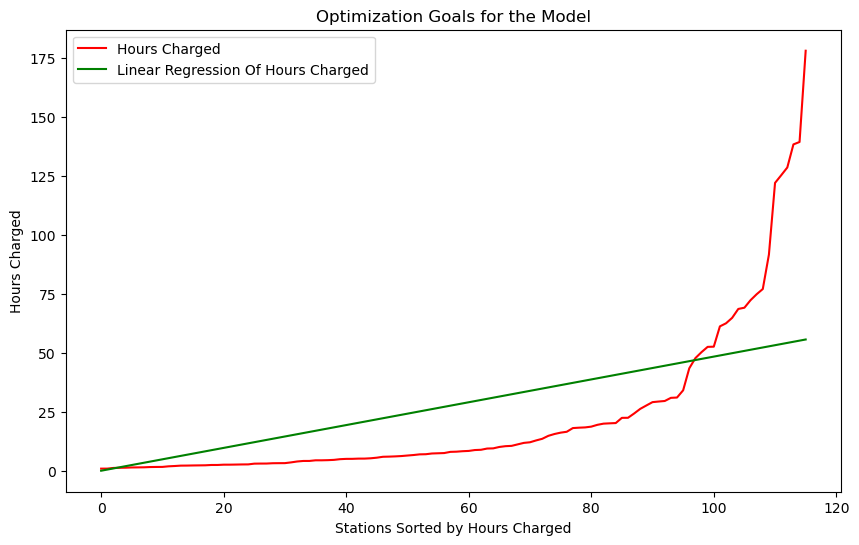

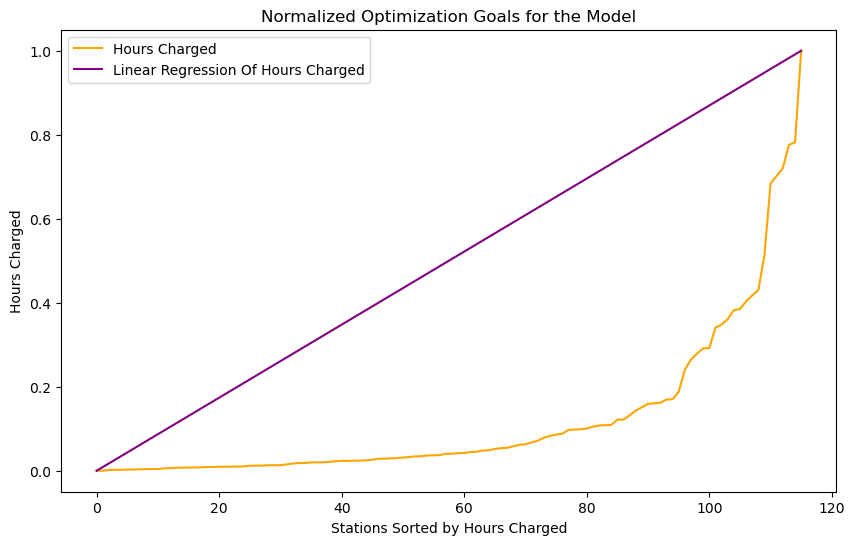

In [15]:
X = np.arange(len(df_moterway)).reshape(-1, 1)  # Element numbers as X
y_original = df_moterway['status_3_ratio_mean'].values.reshape(-1, 1)  # status_3_ratio_mean as Y, reshaped for scaler

# Normalize X and y
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y_original)

# Fit the model
model = LinearRegression(fit_intercept=False)
model.fit(X, y_original)

# Predict using the scaled features
y_lin = model.predict(X)
y_scaled_lin = scaler_y.fit_transform(y_lin)

# Plotting the results (optional)
plt.figure(figsize=(10, 6))
plt.plot(X, y_original, color='red', label='Hours Charged')
plt.plot(X, y_lin, color='green', label='Linear Regression Of Hours Charged')

plt.title('Optimization Goals for the Model')
plt.xlabel('Stations Sorted by Hours Charged')
plt.ylabel('Hours Charged')
plt.legend()
plt.show()

# Plotting the results (optional)
plt.figure(figsize=(10, 6))
plt.plot(X, y_scaled, color='orange', label='Hours Charged')
plt.plot(X, y_scaled_lin, color='purple', label='Linear Regression Of Hours Charged')

plt.title('Normalized Optimization Goals for the Model')
plt.xlabel('Stations Sorted by Hours Charged')
plt.ylabel('Hours Charged')
plt.legend()
plt.show()

c:\Anaconda\envs\RnD\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Anaconda\envs\RnD\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg   	min    	var      	std     
0  	50    	40.214	39.9507	0.0205045	0.143194
1  	32    	40.0661	39.6401	0.016599 	0.128837
2  	35    	39.8808	37.8595	0.219317 	0.468313
3  	30    	39.5759	37.0885	0.581864 	0.7628  
4  	33    	39.0168	36.9634	0.812746 	0.901524
5  	34    	38.408 	36.9634	0.535879 	0.732038
6  	42    	37.8475	33.6051	0.972768 	0.98629 
7  	34    	37.1368	33.5971	0.816339 	0.903515
8  	36    	36.2731	33.482 	1.3851   	1.1769  
9  	43    	35.3586	33.312 	1.01794  	1.00893 
10 	34    	34.3986	33.312 	0.567069 	0.75304 
11 	43    	33.8469	33.2459	0.319902 	0.565599
12 	37    	33.6373	33.2621	0.144264 	0.379821
13 	41    	33.4265	33.2259	0.0378204	0.194475
14 	37    	33.4506	33.2259	0.304683 	0.551981
15 	40    	33.3225	33.2259	0.0293427	0.171297
16 	37    	33.3078	33.2104	0.0821554	0.286628
17 	38    	33.2676	33.1906	0.0225123	0.150041
18 	36    	33.3577	33.1822	0.202022 	0.449469
19 	32    	33.2497	33.1798	0.0251028	0.158439
20 	38    	33.286 	33.1798	0.0893354

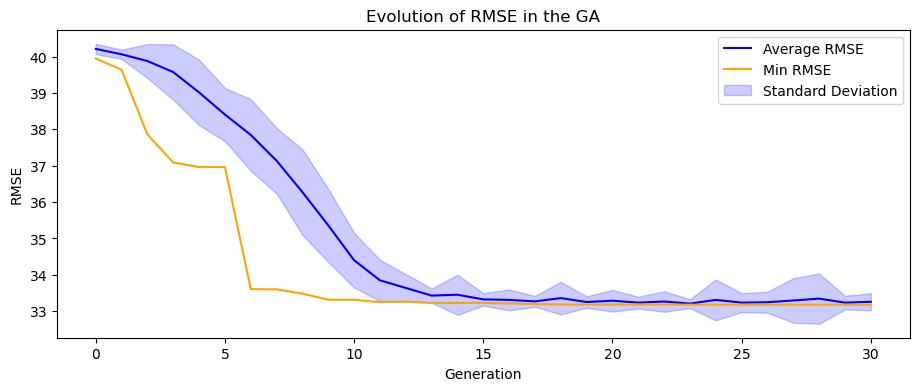

[[0,
  0.2832616556137711,
  0,
  0.10211992470726368,
  0.027451103246829117,
  0.019329675218526857,
  0.001901040946415229]]

Best MSE: 33.174512043243816
Best Weights:
traffic_weight: 0
fastFoods_weight: 0.2832616556137711
hotels_weight: 0
motorwayLinks_weight: 0.10211992470726368
motorways_weight: 0.027451103246829117
restaurants_weight: 0.019329675218526857
shopSupermarkets_weight: 0.001901040946415229
C++ program output:
 Time taken: 545 milliseconds



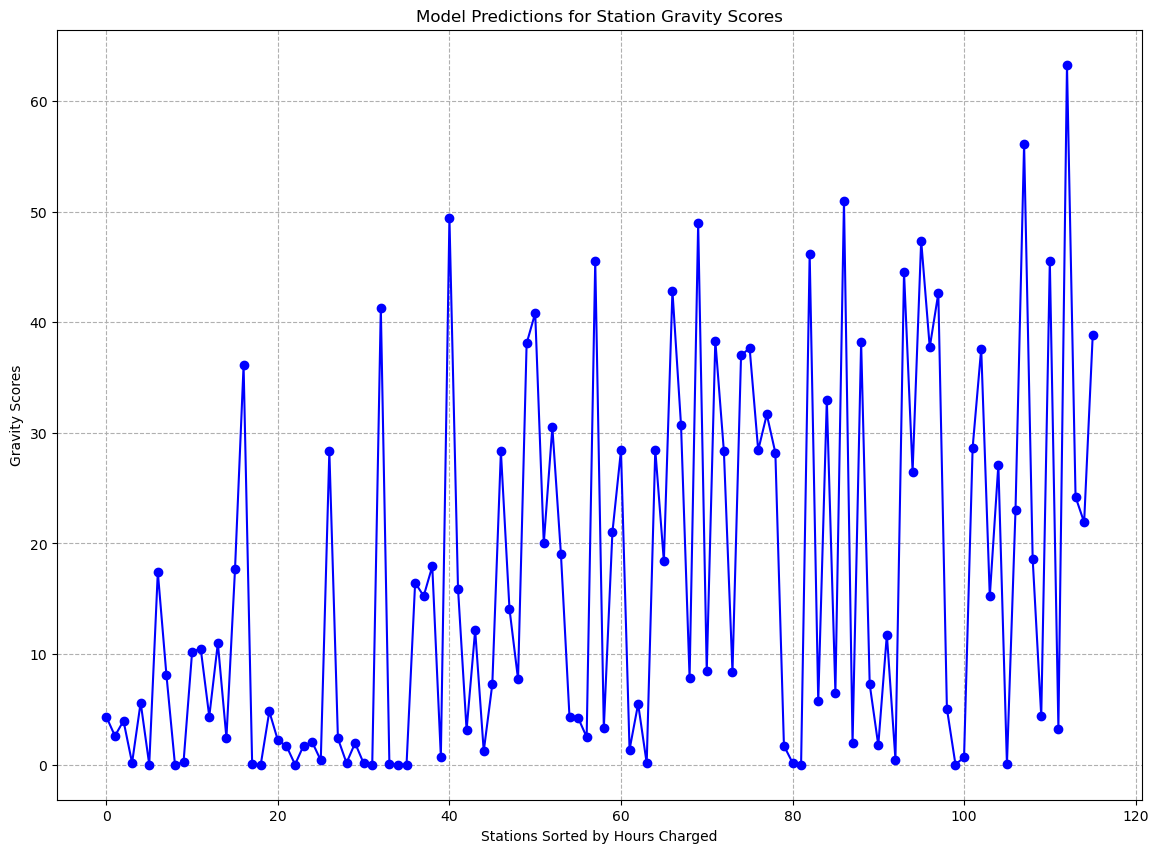

Mean Squared Error (MSE): 1100.5482493073291
Root Mean Squared Error (RMSE): 33.174512043243816
NRMSE: 0.1873297607171596


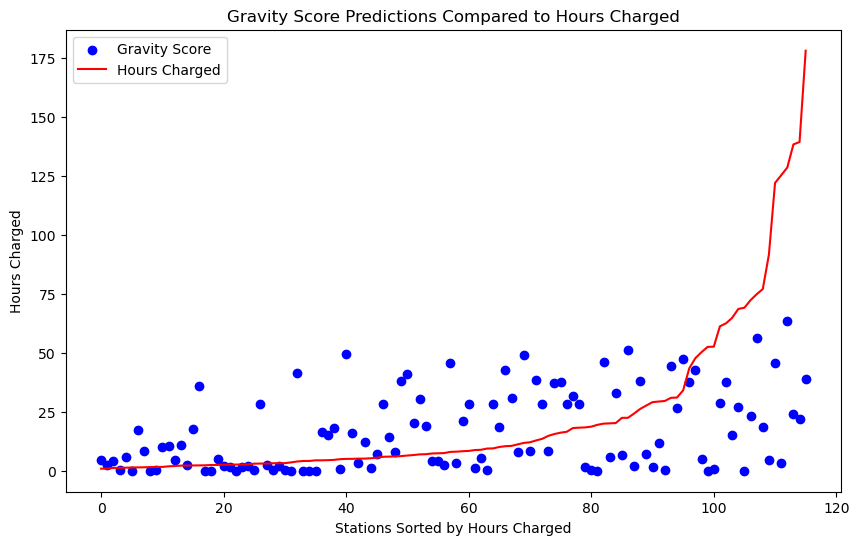

Mean Squared Error (MSE): 439.3740478251729
Root Mean Squared Error (RMSE): 20.961251103528454
NRMSE: 0.3769284108503898


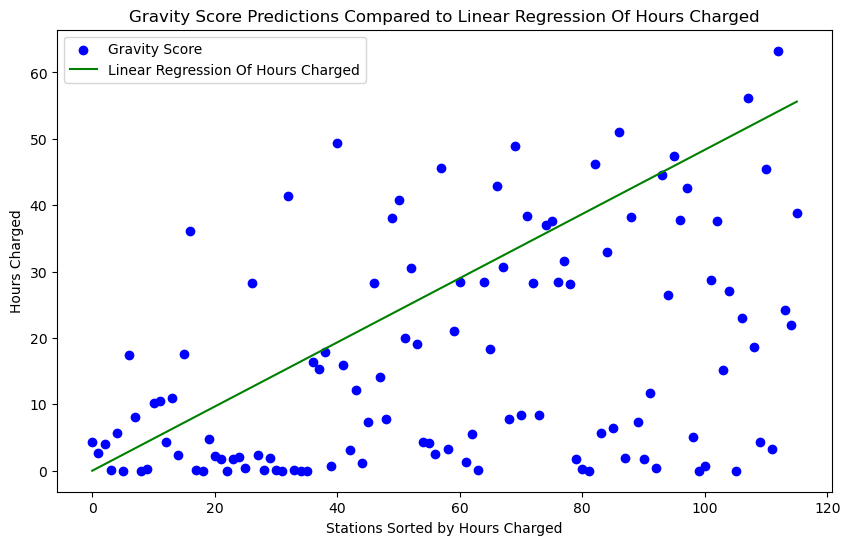

In [31]:
def evaluate(individual):
    # Convert GA individual (set of weights) into your weights' dictionary structure
    new_weights = {name: weight for name, weight in zip(weights.keys(), individual)}

    # Write these new weights into the format your C++ program expects
    with open("weights_float.txt", "w") as file:
        for name, value in new_weights.items():
            file.write(f"{name} {value}\n")

    # Run the C++ program
    try:
        subprocess.run(['./gravityscore', 'moterway.csv'], check=True)
        
        # Process the output CSV file
        df_gravity = pd.read_csv('gravityScoresWithDetails.csv')
        df_gravity['gravity'] = df_gravity['gravity'].apply(lambda x: 0 if x < 0 else x) 
        

        mse = mean_squared_error(y_original, df_gravity['gravity'])
        rmse = np.sqrt(mse)
    except subprocess.CalledProcessError as e:
        print(f"Error running C++ program: {e}")
        rmse = float('inf')  # Assign a high MSE value in case of error

    return (rmse,)

# Genetic algorithm setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0, 0.01)  # Adjust range as needed
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=len(weights))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", custom_cxBlend, alpha=0.5)
toolbox.register("mutate", custom_mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Parameters for the GA
population_size = 50
crossover_probability = 0.7
mutation_probability = 0.2
number_of_generations = 30

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("var", np.var)
stats.register("std", np.std)


population = toolbox.population(n=population_size)
hof = tools.HallOfFame(1)  # To keep track of the best individual ever found

final_population, logbook = algorithms.eaSimple(population, toolbox, cxpb=crossover_probability, mutpb=mutation_probability, ngen=number_of_generations, stats=stats, halloffame=hof, verbose=True)

# Assuming logbook is already defined and populated
gen = np.array(logbook.select("gen"))
avg_mse = np.array(logbook.select("avg"))
min_mse = np.array(logbook.select("min"))
std_mse = np.array(logbook.select("std"))

# Calculate the upper and lower bounds for the shaded area
upper_bound = avg_mse + std_mse
lower_bound = avg_mse - std_mse

# Plot the graph
plt.figure(figsize=(11, 4))
plt.title("Evolution of RMSE in the GA")
plt.plot(gen, avg_mse, label="Average RMSE", color="blue")
plt.plot(gen, min_mse, label="Min RMSE", color="orange")
plt.fill_between(gen, lower_bound, upper_bound, color='blue', alpha=0.2, label="Standard Deviation")
plt.xlabel("Generation")
plt.ylabel("RMSE")
plt.legend()
plt.show()
display(hof.items)
# Assuming 'hof' is your HallOfFame object
best_individual = hof[0]  # The best individual
best_weights = {name: weight for name, weight in zip(weights.keys(), best_individual)}
best_mse = best_individual.fitness.values[0]

print("Best MSE:", best_mse)
print("Best Weights:")
for name, weight in best_weights.items():
    print(f"{name}: {weight}")
with open("weights_float.txt", "w") as file:
    for name, value in best_weights.items():
        file.write(f"{name} {float(value)}\n")
# Define the path to the compiled executable
executable_path = './gravityscore'

# The CSV file name to pass as an argument
csv_file_name = 'moterway.csv'

# Run the compiled C++ program with the CSV file name as an argument
result = subprocess.run([executable_path, csv_file_name], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

# Process the result
if result.returncode == 0:
    print("C++ program output:\n", result.stdout)
else:
    print("Error running C++ program:\n", result.stderr)
df_gravity = pd.read_csv('gravityScoresWithDetails.csv')
#change all gravity that a negative to zero
df_gravity['gravity'] = df_gravity['gravity'].apply(lambda x: 0 if x < 0 else x)

#plot df_gravity where x asis the the index and y axis the gravity
plt.figure(figsize=(14, 10))
plt.plot(df_gravity.index, df_gravity['gravity'], marker='o', linestyle='-', color='blue')
plt.xlabel('Stations Sorted by Hours Charged')
plt.ylabel('Gravity Scores')
plt.title('Model Predictions for Station Gravity Scores')
plt.grid(True, which="both", ls="--")
plt.show()
def nrmse(y_true, rmse_value):
    """Calculate the Normalized Root Mean Square Error."""
    range_value = np.max(y_true) - np.min(y_true)
    return rmse_value / range_value


X = np.arange(len(df_moterway)).reshape(-1, 1)  # Element numbers as X
y = df_gravity['gravity'].values.reshape(-1, 1)
#y_original = df_moterway['status_3_ratio_mean'].values.reshape(-1, 1)  # status_3_ratio_mean as Y, reshaped for scaler


scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_gravity_scaled = scaler_y.fit_transform(y)


# Calculate MSE on the scaled predictions
mse = mean_squared_error(y, y_original)
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
nrmse_value = nrmse(y_original, rmse)
print(f"NRMSE: {nrmse_value}")

# Plotting the results (optional)
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Gravity Score')
plt.plot(X, y_original, color='red', label='Hours Charged')
plt.title('Gravity Score Predictions Compared to Hours Charged')
plt.xlabel('Stations Sorted by Hours Charged')
plt.ylabel('Hours Charged')
plt.legend()
plt.show()


# Calculate MSE on the scaled predictions
mse = mean_squared_error(y, y_lin)
rmse = np.sqrt(mse)
rmse = np.sqrt(mse)
nrmse_value = nrmse(y_lin, rmse)


print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"NRMSE: {nrmse_value}")


# Plotting the results (optional)
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Gravity Score')
plt.plot(X, y_lin, color='green', label='Linear Regression Of Hours Charged')
plt.title('Gravity Score Predictions Compared to Linear Regression Of Hours Charged')
plt.xlabel('Stations Sorted by Hours Charged')
plt.ylabel('Hours Charged')
plt.legend()
plt.show()

In [32]:
def evaluate(individual):
    # Convert GA individual (set of weights) into your weights' dictionary structure
    new_weights = {name: weight for name, weight in zip(weights.keys(), individual)}

    # Write these new weights into the format your C++ program expects
    with open("weights_float.txt", "w") as file:
        for name, value in new_weights.items():
            file.write(f"{name} {value}\n")

    # Run the C++ program
    try:
        subprocess.run(['./gravityscore', 'moterway.csv'], check=True)
        
        # Process the output CSV file
        df_gravity = pd.read_csv('gravityScoresWithDetails.csv')
        df_gravity['gravity'] = df_gravity['gravity'].apply(lambda x: 0 if x < 0 else x) 
        

        mse = mean_squared_error(y_lin, df_gravity['gravity'])
        rmse = np.sqrt(mse)
    except subprocess.CalledProcessError as e:
        print(f"Error running C++ program: {e}")
        rmse = float('inf')  # Assign a high MSE value in case of error

    return (rmse,)

# Genetic algorithm setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0, 0.01)  # Adjust range as needed
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=len(weights))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", custom_cxBlend, alpha=0.5)
toolbox.register("mutate", custom_mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Parameters for the GA
population_size = 50
crossover_probability = 0.7
mutation_probability = 0.2
number_of_generations = 30

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("var", np.var)
stats.register("std", np.std)


population = toolbox.population(n=population_size)
hof = tools.HallOfFame(1)  # To keep track of the best individual ever found

final_population, logbook = algorithms.eaSimple(population, toolbox, cxpb=crossover_probability, mutpb=mutation_probability, ngen=number_of_generations, stats=stats, halloffame=hof, verbose=True)


c:\Anaconda\envs\RnD\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Anaconda\envs\RnD\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg    	min    	var      	std     
0  	50    	31.6034	31.2036	0.0391044	0.197748
1  	43    	31.2981	26.3877	0.605635 	0.778226
2  	38    	30.8202	24.4884	1.73734  	1.31808 
3  	41    	29.6559	23.2724	4.95156  	2.22521 
4  	36    	28.0657	22.536 	7.29803  	2.70149 
5  	35    	26.274 	22.705 	4.77442  	2.18504 
6  	37    	24.7008	20.9624	4.73601  	2.17624 
7  	37    	23.2558	20.9624	2.46207  	1.5691  
8  	34    	22.2546	20.6929	1.59755  	1.26394 
9  	37    	21.3506	20.6002	0.834649 	0.913591
10 	40    	20.8831	20.3465	0.118438 	0.344148
11 	38    	20.6823	20.3928	0.0699234	0.26443 
12 	37    	20.6179	20.2799	0.0522472	0.228576
13 	35    	20.4733	20.1888	0.0211726	0.145508
14 	44    	20.4423	20.1737	0.0434254	0.208388
15 	43    	20.318 	20.0827	0.0136376	0.11678 
16 	35    	20.428 	20.1001	0.516188 	0.718462
17 	37    	20.4422	20.0594	1.50845  	1.22819 
18 	42    	20.2533	20.0639	0.105622 	0.324996
19 	37    	20.3293	20.0632	0.921144 	0.959763
20 	39    	20.2462	20.0494	0.37407

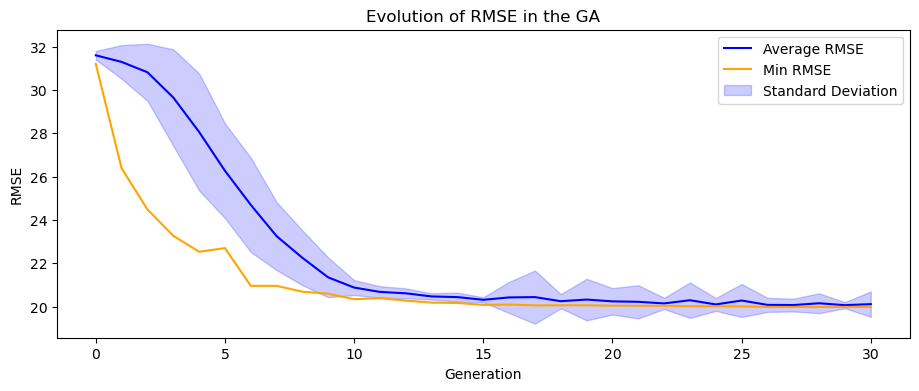

In [33]:
# Assuming logbook is already defined and populated
gen = np.array(logbook.select("gen"))
avg_mse = np.array(logbook.select("avg"))
min_mse = np.array(logbook.select("min"))
std_mse = np.array(logbook.select("std"))

# Calculate the upper and lower bounds for the shaded area
upper_bound = avg_mse + std_mse
lower_bound = avg_mse - std_mse

# Plot the graph
plt.figure(figsize=(11, 4))
plt.title("Evolution of RMSE in the GA")
plt.plot(gen, avg_mse, label="Average RMSE", color="blue")
plt.plot(gen, min_mse, label="Min RMSE", color="orange")
plt.fill_between(gen, lower_bound, upper_bound, color='blue', alpha=0.2, label="Standard Deviation")
plt.xlabel("Generation")
plt.ylabel("RMSE")
plt.legend()
plt.show()

In [34]:
display(hof.items)
# Assuming 'hof' is your HallOfFame object
best_individual = hof[0]  # The best individual
best_weights = {name: weight for name, weight in zip(weights.keys(), best_individual)}
best_mse = best_individual.fitness.values[0]

print("Best MSE:", best_mse)
print("Best Weights:")
for name, weight in best_weights.items():
    print(f"{name}: {weight}")

[[0.0012742605850531049,
  0.2474721506359849,
  0.0011465828968701373,
  0.11629016576355938,
  0.17093587715224196,
  0.20143715998137027,
  0.11371507126336369]]

Best MSE: 19.987683913503826
Best Weights:
traffic_weight: 0.0012742605850531049
fastFoods_weight: 0.2474721506359849
hotels_weight: 0.0011465828968701373
motorwayLinks_weight: 0.11629016576355938
motorways_weight: 0.17093587715224196
restaurants_weight: 0.20143715998137027
shopSupermarkets_weight: 0.11371507126336369


In [35]:
with open("weights_float.txt", "w") as file:
    for name, value in best_weights.items():
        file.write(f"{name} {float(value)}\n")

In [36]:
# Define the path to the compiled executable
executable_path = './gravityscore'

# The CSV file name to pass as an argument
csv_file_name = 'moterway.csv'

# Run the compiled C++ program with the CSV file name as an argument
result = subprocess.run([executable_path, csv_file_name], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

# Process the result
if result.returncode == 0:
    print("C++ program output:\n", result.stdout)
else:
    print("Error running C++ program:\n", result.stderr)

C++ program output:
 Time taken: 505 milliseconds



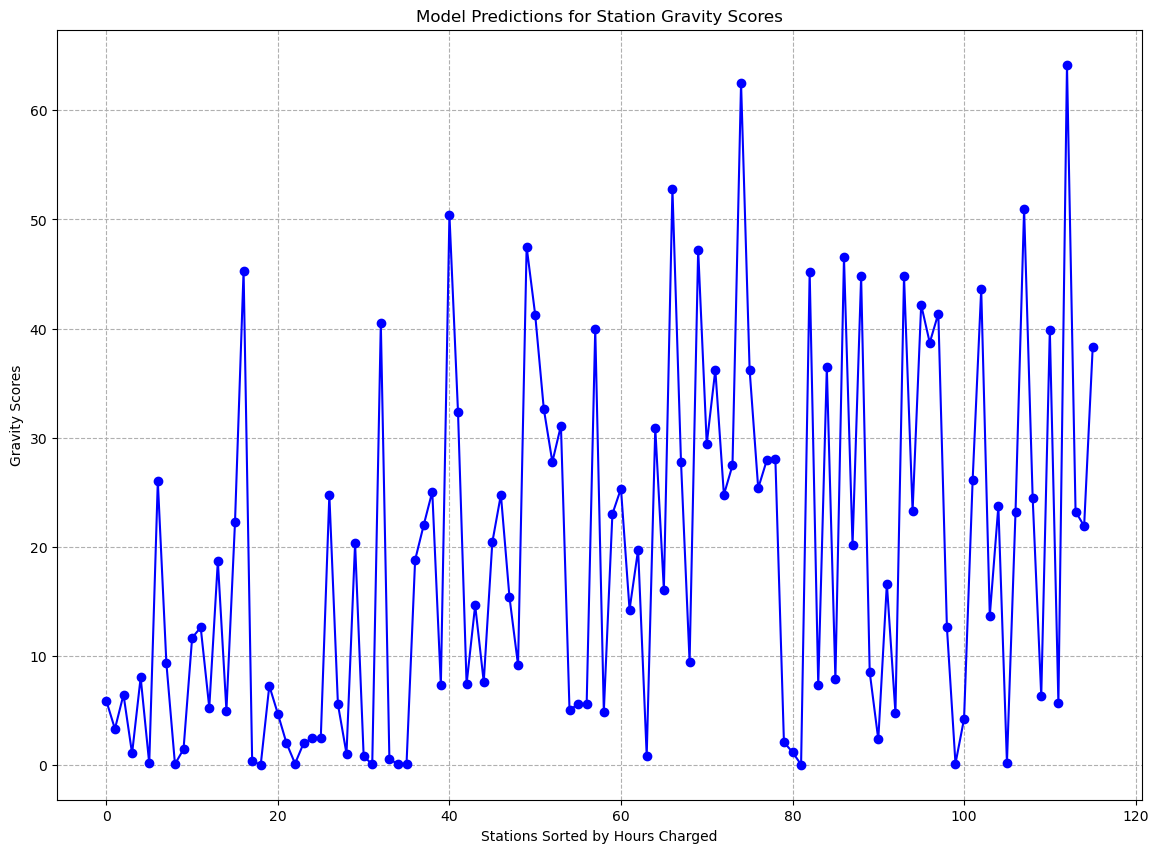

In [37]:
df_gravity = pd.read_csv('gravityScoresWithDetails.csv')
#change all gravity that a negative to zero
df_gravity['gravity'] = df_gravity['gravity'].apply(lambda x: 0 if x < 0 else x)

#plot df_gravity where x asis the the index and y axis the gravity
plt.figure(figsize=(14, 10))
plt.plot(df_gravity.index, df_gravity['gravity'], marker='o', linestyle='-', color='blue')
plt.xlabel('Stations Sorted by Hours Charged')
plt.ylabel('Gravity Scores')
plt.title('Model Predictions for Station Gravity Scores')
plt.grid(True, which="both", ls="--")
plt.show()

Mean Squared Error (MSE): 1138.5653278757768
Root Mean Squared Error (RMSE): 33.74263368315782
NRMSE: 0.1905378287280651


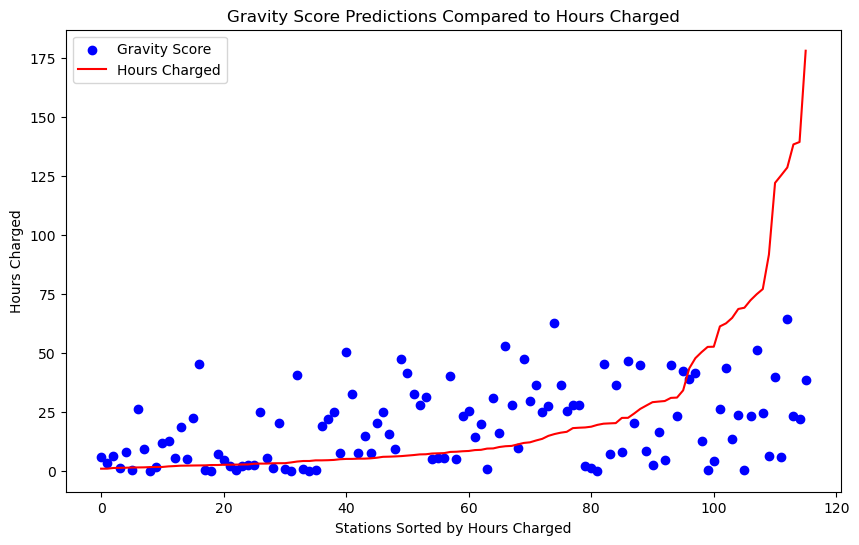

Mean Squared Error (MSE): 399.50750822613963
Root Mean Squared Error (RMSE): 19.987683913503826
NRMSE: 0.3594215773136125


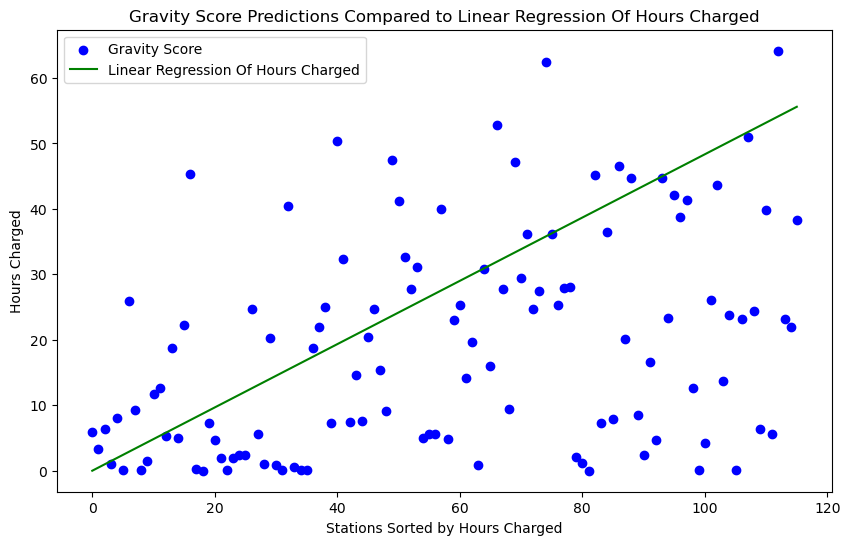

In [38]:
def nrmse(y_true, rmse_value):
    """Calculate the Normalized Root Mean Square Error."""
    range_value = np.max(y_true) - np.min(y_true)
    return rmse_value / range_value


X = np.arange(len(df_moterway)).reshape(-1, 1)  # Element numbers as X
y = df_gravity['gravity'].values.reshape(-1, 1)
#y_original = df_moterway['status_3_ratio_mean'].values.reshape(-1, 1)  # status_3_ratio_mean as Y, reshaped for scaler


scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_gravity_scaled = scaler_y.fit_transform(y)


# Calculate MSE on the scaled predictions
mse = mean_squared_error(y, y_original)
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
nrmse_value = nrmse(y_original, rmse)
print(f"NRMSE: {nrmse_value}")

# Plotting the results (optional)
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Gravity Score')
plt.plot(X, y_original, color='red', label='Hours Charged')
plt.title('Gravity Score Predictions Compared to Hours Charged')
plt.xlabel('Stations Sorted by Hours Charged')
plt.ylabel('Hours Charged')
plt.legend()
plt.show()


# Calculate MSE on the scaled predictions
mse = mean_squared_error(y, y_lin)
rmse = np.sqrt(mse)
rmse = np.sqrt(mse)
nrmse_value = nrmse(y_lin, rmse)


print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"NRMSE: {nrmse_value}")


# Plotting the results (optional)
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Gravity Score')
plt.plot(X, y_lin, color='green', label='Linear Regression Of Hours Charged')
plt.title('Gravity Score Predictions Compared to Linear Regression Of Hours Charged')
plt.xlabel('Stations Sorted by Hours Charged')
plt.ylabel('Hours Charged')
plt.legend()
plt.show()

c:\Anaconda\envs\RnD\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Anaconda\envs\RnD\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg     	min     	var       	std      
0  	50    	0.319029	0.257301	0.00037648	0.0194031
1  	39    	0.309945	0.245258	0.000507132	0.0225196
2  	38    	0.291264	0.227829	0.00062566 	0.0250132
3  	35    	0.277402	0.21982 	0.000617045	0.0248404
4  	37    	0.262649	0.21982 	0.000767944	0.0277118
5  	41    	0.240622	0.220326	0.000287954	0.0169692
6  	34    	0.233181	0.220107	0.000214013	0.0146292
7  	36    	0.228768	0.220369	0.000101067	0.0100532
8  	42    	0.229516	0.218797	0.000385795	0.0196417
9  	42    	0.225174	0.218797	0.000215714	0.0146872
10 	39    	0.223759	0.218797	0.000238112	0.0154309
11 	41    	0.222798	0.218727	0.000173903	0.0131872
12 	34    	0.21983 	0.218727	4.85822e-06	0.00220414
13 	34    	0.219271	0.218615	1.23961e-06	0.00111338
14 	36    	0.221413	0.218219	0.000118359	0.0108793 
15 	31    	0.22058 	0.218219	6.4975e-05 	0.0080607 
16 	37    	0.220443	0.218164	3.42126e-05	0.00584915
17 	40    	0.219454	0.218136	1.60887e-05	0.00401107
18 	35    	0.219139	0.21816

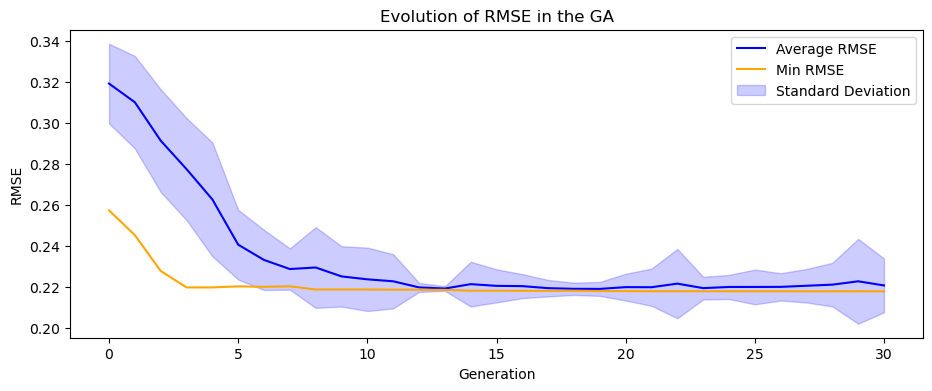

Best MSE: 0.21791387306000887
Best Weights:
traffic_weight: 0
fastFoods_weight: 58.36822359270499
hotels_weight: 261.52118360738245
motorwayLinks_weight: 18.60389649072072
motorways_weight: 1.7312577363270936
restaurants_weight: 0
shopSupermarkets_weight: 0
C++ program output:
 Time taken: 574 milliseconds



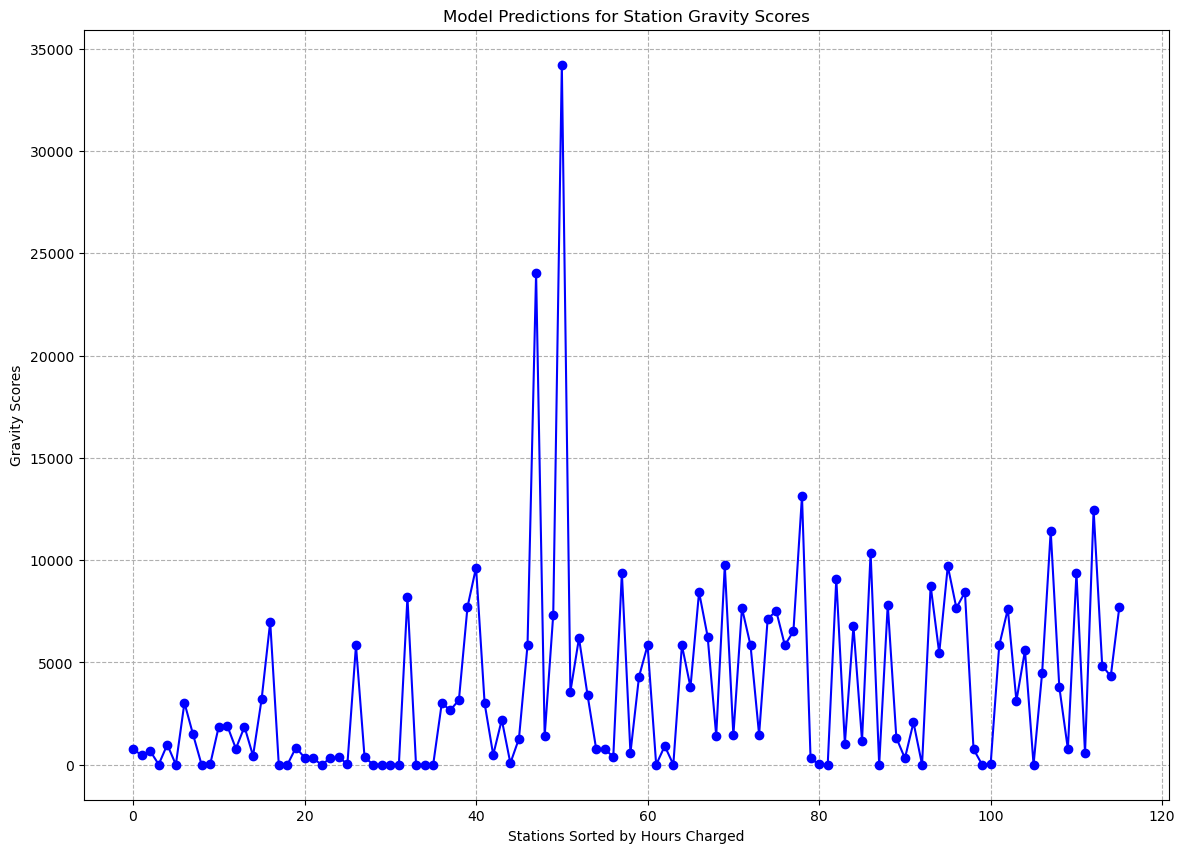

Mean Squared Error (MSE) on scaled data: 0.047486456072013655
Root Mean Squared Error (RMSE) on scaled data: 0.21791387306000887


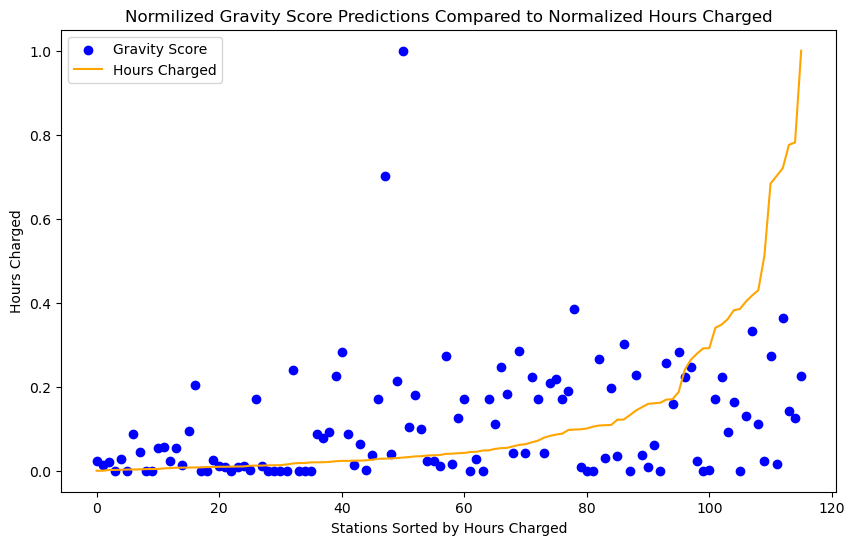

Mean Squared Error (MSE) on scaled data: 0.23404718604951955
Root Mean Squared Error (RMSE) on scaled data: 0.48378423501548656


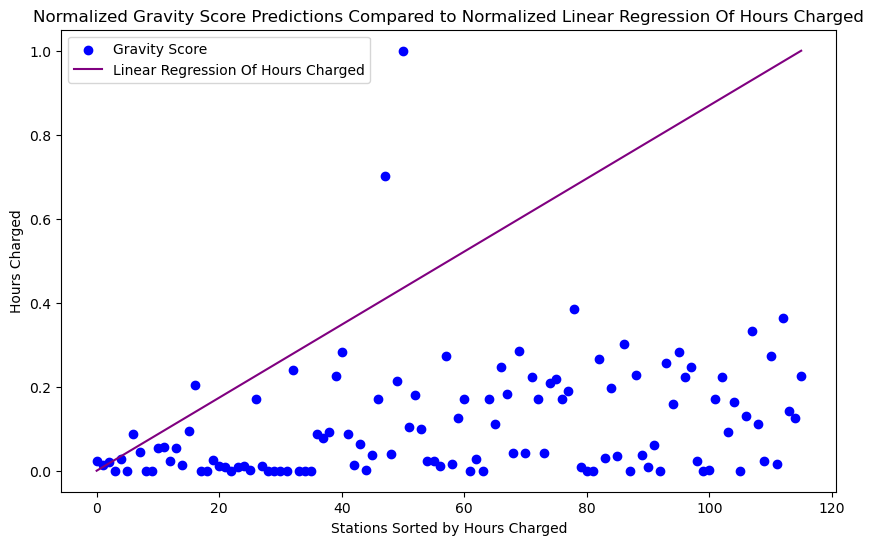

In [39]:
def evaluate(individual):
    # Convert GA individual (set of weights) into your weights' dictionary structure
    new_weights = {name: weight for name, weight in zip(weights.keys(), individual)}

    # Write these new weights into the format your C++ program expects
    with open("weights_float.txt", "w") as file:
        for name, value in new_weights.items():
            file.write(f"{name} {value}\n")

    # Run the C++ program
    try:
        subprocess.run(['./gravityscore', 'moterway.csv'], check=True)
        
        # Process the output CSV file
        df_gravity = pd.read_csv('gravityScoresWithDetails.csv')
        df_gravity['gravity'] = df_gravity['gravity'].apply(lambda x: 0 if x < 0 else x)

        # Assuming df_gravity['gravity'] needs to be scaled between 0 and 1 to compare with y_true
        # If df_gravity['gravity'] is already scaled, this step can be adjusted or removed
        scaler = MinMaxScaler()
        y_pred_scaled = scaler.fit_transform(df_gravity[['gravity']]).flatten()

        mse = mean_squared_error(y_scaled, y_pred_scaled)
        rmse = np.sqrt(mse)
    except subprocess.CalledProcessError as e:
        print(f"Error running C++ program: {e}")
        rmse = float('inf')  # Assign a high MSE value in case of error

    return (rmse,)

# Genetic algorithm setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0, 100)  # Adjust range as needed
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=len(weights))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", custom_cxBlend, alpha=0.5)
toolbox.register("mutate", custom_mutGaussian, mu=0, sigma=100, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Parameters for the GA
population_size = 50
crossover_probability = 0.7
mutation_probability = 0.2
number_of_generations = 30

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("var", np.var)
stats.register("std", np.std)


population = toolbox.population(n=population_size)
hof = tools.HallOfFame(1)  # To keep track of the best individual ever found

final_population, logbook = algorithms.eaSimple(population, toolbox, cxpb=crossover_probability, mutpb=mutation_probability, ngen=number_of_generations, stats=stats, halloffame=hof, verbose=True)

# Assuming logbook is already defined and populated
gen = np.array(logbook.select("gen"))
avg_mse = np.array(logbook.select("avg"))
min_mse = np.array(logbook.select("min"))
std_mse = np.array(logbook.select("std"))

# Calculate the upper and lower bounds for the shaded area
upper_bound = avg_mse + std_mse
lower_bound = avg_mse - std_mse

# Plot the graph
plt.figure(figsize=(11, 4))
plt.title("Evolution of RMSE in the GA")
plt.plot(gen, avg_mse, label="Average RMSE", color="blue")
plt.plot(gen, min_mse, label="Min RMSE", color="orange")
plt.fill_between(gen, lower_bound, upper_bound, color='blue', alpha=0.2, label="Standard Deviation")
plt.xlabel("Generation")
plt.ylabel("RMSE")
plt.legend()
plt.show()

# Assuming 'hof' is your HallOfFame object
best_individual = hof[0]  # The best individual
best_weights = {name: weight for name, weight in zip(weights.keys(), best_individual)}
best_mse = best_individual.fitness.values[0]

print("Best MSE:", best_mse)
print("Best Weights:")
for name, weight in best_weights.items():
    print(f"{name}: {weight}")

with open("weights_float.txt", "w") as file:
    for name, value in best_weights.items():
        file.write(f"{name} {float(value)}\n")

# Define the path to the compiled executable
executable_path = './gravityscore'

# The CSV file name to pass as an argument
csv_file_name = 'moterway.csv'

# Run the compiled C++ program with the CSV file name as an argument
result = subprocess.run([executable_path, csv_file_name], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

# Process the result
if result.returncode == 0:
    print("C++ program output:\n", result.stdout)
else:
    print("Error running C++ program:\n", result.stderr)

df_gravity = pd.read_csv('gravityScoresWithDetails.csv')
#change all gravity that a negative to zero
df_gravity['gravity'] = df_gravity['gravity'].apply(lambda x: 0 if x < 0 else x)

#plot df_gravity where x asis the the index and y axis the gravity
plt.figure(figsize=(14, 10))
plt.plot(df_gravity.index, df_gravity['gravity'], marker='o', linestyle='-', color='blue')
plt.xlabel('Stations Sorted by Hours Charged')
plt.ylabel('Gravity Scores')
plt.title('Model Predictions for Station Gravity Scores')
plt.grid(True, which="both", ls="--")
plt.show()
X = np.arange(len(df_moterway)).reshape(-1, 1)  # Element numbers as X
y = df_gravity['gravity'].values.reshape(-1, 1)
#y_original = df_moterway['status_3_ratio_mean'].values.reshape(-1, 1)  # status_3_ratio_mean as Y, reshaped for scaler


scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_gravity_scaled = scaler_y.fit_transform(y)


# Calculate MSE on the scaled predictions
mse_scaled = mean_squared_error(y_gravity_scaled, y_scaled)
rmse = np.sqrt(mse_scaled)

mse = mean_squared_error(y, y_original)

print(f"Mean Squared Error (MSE) on scaled data: {mse_scaled}")
print(f"Root Mean Squared Error (RMSE) on scaled data: {rmse}")


# Plotting the results (optional)
plt.figure(figsize=(10, 6))
plt.scatter(X, y_gravity_scaled, color='blue', label='Gravity Score')
plt.plot(X, y_scaled, color='orange', label='Hours Charged')
plt.title('Normilized Gravity Score Predictions Compared to Normalized Hours Charged')
plt.xlabel('Stations Sorted by Hours Charged')
plt.ylabel('Hours Charged')
plt.legend()
plt.show()


# Calculate MSE on the scaled predictions
mse_scaled = mean_squared_error(y_gravity_scaled, y_scaled_lin)
rmse = np.sqrt(mse_scaled)

# If you want to calculate MSE on the original scale
mse = mean_squared_error(y, y_original)

print(f"Mean Squared Error (MSE) on scaled data: {mse_scaled}")
print(f"Root Mean Squared Error (RMSE) on scaled data: {rmse}")

# Plotting the results (optional)
plt.figure(figsize=(10, 6))
plt.scatter(X, y_gravity_scaled, color='blue', label='Gravity Score')
plt.plot(X, y_scaled_lin, color='purple', label='Linear Regression Of Hours Charged')
plt.title('Normalized Gravity Score Predictions Compared to Normalized Linear Regression Of Hours Charged')
plt.xlabel('Stations Sorted by Hours Charged')
plt.ylabel('Hours Charged')
plt.legend()
plt.show()


In [40]:
def evaluate(individual):
    # Convert GA individual (set of weights) into your weights' dictionary structure
    new_weights = {name: weight for name, weight in zip(weights.keys(), individual)}

    # Write these new weights into the format your C++ program expects
    with open("weights_float.txt", "w") as file:
        for name, value in new_weights.items():
            file.write(f"{name} {value}\n")

    # Run the C++ program
    try:
        subprocess.run(['./gravityscore', 'moterway.csv'], check=True)
        
        # Process the output CSV file
        df_gravity = pd.read_csv('gravityScoresWithDetails.csv')
        df_gravity['gravity'] = df_gravity['gravity'].apply(lambda x: 0 if x < 0 else x)

        # Assuming df_gravity['gravity'] needs to be scaled between 0 and 1 to compare with y_true
        # If df_gravity['gravity'] is already scaled, this step can be adjusted or removed
        scaler = MinMaxScaler()
        y_pred_scaled = scaler.fit_transform(df_gravity[['gravity']]).flatten()

        mse = mean_squared_error(y_scaled_lin, y_pred_scaled)
        rmse = np.sqrt(mse)
    except subprocess.CalledProcessError as e:
        print(f"Error running C++ program: {e}")
        rmse = float('inf')  # Assign a high MSE value in case of error

    return (rmse,)

# Genetic algorithm setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0, 100)  # Adjust range as needed
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=len(weights))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", custom_cxBlend, alpha=0.5)
toolbox.register("mutate", custom_mutGaussian, mu=0, sigma=100, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Parameters for the GA
population_size = 50
crossover_probability = 0.7
mutation_probability = 0.2
number_of_generations = 30

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("var", np.var)
stats.register("std", np.std)


population = toolbox.population(n=population_size)
hof = tools.HallOfFame(1)  # To keep track of the best individual ever found

final_population, logbook = algorithms.eaSimple(population, toolbox, cxpb=crossover_probability, mutpb=mutation_probability, ngen=number_of_generations, stats=stats, halloffame=hof, verbose=True)


c:\Anaconda\envs\RnD\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Anaconda\envs\RnD\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg     	min     	var        	std      
0  	50    	0.404858	0.373508	0.000618398	0.0248676
1  	28    	0.38904 	0.368696	0.00018526 	0.013611 
2  	37    	0.385808	0.369161	0.000309949	0.0176054
3  	34    	0.380052	0.368557	5.40772e-05	0.00735372
4  	36    	0.377149	0.368398	0.000153738	0.0123991 
5  	31    	0.374379	0.365949	0.0001062  	0.0103053 
6  	39    	0.373925	0.364347	0.00015328 	0.0123806 
7  	28    	0.370348	0.364347	2.08565e-05	0.00456689
8  	41    	0.372175	0.364347	0.000246881	0.0157125 
9  	40    	0.368188	0.364347	1.73435e-05	0.00416455
10 	43    	0.36862 	0.363351	7.07664e-05	0.00841228
11 	42    	0.374279	0.362863	0.000456552	0.0213671 
12 	36    	0.367991	0.362863	0.000137042	0.0117065 
13 	33    	0.365591	0.362824	1.78676e-05	0.00422701
14 	39    	0.366391	0.362691	4.37097e-05	0.00661133
15 	35    	0.36531 	0.36262 	5.18032e-05	0.00719744
16 	37    	0.363381	0.362248	1.58726e-06	0.00125987
17 	37    	0.371015	0.362352	0.000637563	0.02525   
18 	32    	0.367

In [20]:
def evaluate(individual):
    new_weights = {name: weight for name, weight in zip(weights.keys(), individual)}

    with open("weights_float.txt", "w") as file:
        for name, value in new_weights.items():
            file.write(f"{name} {value}\n")

    try:
        subprocess.run(['./gravityscore', 'moterway.csv'], check=True)
        df_gravity = pd.read_csv('gravityScoresWithDetails.csv')
        df_gravity['gravity'] = df_gravity['gravity'].apply(lambda x: 0 if x < 0 else x)

        scaler = MinMaxScaler()
        y_pred_scaled = scaler.fit_transform(df_gravity[['gravity']]).flatten()

        mse = mean_squared_error(y_scaled_lin, y_pred_scaled)
        rmse = np.sqrt(mse)
    except subprocess.CalledProcessError as e:
        print(f"Error running C++ program: {e}")
        rmse = float('inf')

    return (rmse,)

# Genetic algorithm setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0, 100)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=len(weights))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", custom_cxBlend, alpha=0.5)
toolbox.register("mutate", custom_mutGaussian, mu=0, sigma=100, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Parameters for the GA
population_size = 50
number_of_generations = 20

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("var", np.var)
stats.register("std", np.std)

# Lists to hold the results
results = []

# Range of crossover and mutation probabilities to test
crossover_probs = [0.3, 0.4, 0.5, 0.6, 0.7]
mutation_probs = [0.1, 0.2, 0.3, 0.4, 0.5]

for cxpb in crossover_probs:
    for mutpb in mutation_probs:
        print(f"Testing with crossover probability: {cxpb} and mutation probability: {mutpb}")
        
        # Initialize population and Hall of Fame
        population = toolbox.population(n=population_size)
        hof = tools.HallOfFame(1)
        
        # Run the GA
        final_population, logbook = algorithms.eaSimple(population, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=number_of_generations, stats=stats, halloffame=hof, verbose=False)
        
        # Record the results
        best_individual = hof[0]
        best_rmse = best_individual.fitness.values[0]
        results.append((cxpb, mutpb, best_rmse))
        print(f"Crossover: {cxpb}, Mutation: {mutpb}, Best RMSE: {best_rmse}")

# Display the results
for result in results:
    print(f"Crossover: {result[0]}, Mutation: {result[1]}, Best RMSE: {result[2]}")

# Optional: Convert results to DataFrame for better visualization
df_results = pd.DataFrame(results, columns=['Crossover', 'Mutation', 'Best RMSE'])
print(df_results)

Testing with crossover probability: 0.3 and mutation probability: 0.1


c:\Users\basti\anaconda3\envs\RnDenv\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\basti\anaconda3\envs\RnDenv\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Crossover: 0.3, Mutation: 0.1, Best RMSE: 0.36344260806373657
Testing with crossover probability: 0.3 and mutation probability: 0.2
Crossover: 0.3, Mutation: 0.2, Best RMSE: 0.3628797776594847
Testing with crossover probability: 0.3 and mutation probability: 0.3
Crossover: 0.3, Mutation: 0.3, Best RMSE: 0.3628726482047759
Testing with crossover probability: 0.3 and mutation probability: 0.4
Crossover: 0.3, Mutation: 0.4, Best RMSE: 0.36358588174178086
Testing with crossover probability: 0.3 and mutation probability: 0.5
Crossover: 0.3, Mutation: 0.5, Best RMSE: 0.36355726193402854
Testing with crossover probability: 0.4 and mutation probability: 0.1
Crossover: 0.4, Mutation: 0.1, Best RMSE: 0.36280502354602356
Testing with crossover probability: 0.4 and mutation probability: 0.2
Crossover: 0.4, Mutation: 0.2, Best RMSE: 0.3626742468550081
Testing with crossover probability: 0.4 and mutation probability: 0.3
Crossover: 0.4, Mutation: 0.3, Best RMSE: 0.36251258202292513
Testing with cros

In [24]:
def evaluate(individual):
    new_weights = {name: weight for name, weight in zip(weights.keys(), individual)}

    with open("weights_float.txt", "w") as file:
        for name, value in new_weights.items():
            file.write(f"{name} {value}\n")

    try:
        subprocess.run(['./gravityscore', 'moterway.csv'], check=True)
        df_gravity = pd.read_csv('gravityScoresWithDetails.csv')
        df_gravity['gravity'] = df_gravity['gravity'].apply(lambda x: 0 if x < 0 else x)

        scaler = MinMaxScaler()
        y_pred_scaled = scaler.fit_transform(df_gravity[['gravity']]).flatten()

        mse = mean_squared_error(y_scaled_lin, y_pred_scaled)
        rmse = np.sqrt(mse)
    except subprocess.CalledProcessError as e:
        print(f"Error running C++ program: {e}")
        rmse = float('inf')

    return (rmse,)

# Genetic algorithm setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0, 100)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=len(weights))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", custom_cxBlend, alpha=0.5)
toolbox.register("mutate", custom_mutGaussian, mu=0, sigma=100, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Parameters for the GA
population_size = 50
number_of_generations = 30

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("var", np.var)
stats.register("std", np.std)

# Lists to hold the results
results = []

# Range of crossover and mutation probabilities to test
crossover_probs = [0.3, 0.4, 0.5, 0.6, 0.7]
mutation_probs = [0.03, 0.04, 0.05, 0.06, 0.07]

for cxpb in crossover_probs:
    for mutpb in mutation_probs:
        print(f"Testing with crossover probability: {cxpb} and mutation probability: {mutpb}")
        
        # Initialize population and Hall of Fame
        population = toolbox.population(n=population_size)
        hof = tools.HallOfFame(1)
        
        # Run the GA
        final_population, logbook = algorithms.eaSimple(population, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=number_of_generations, stats=stats, halloffame=hof, verbose=False)
        
        # Record the results
        best_individual = hof[0]
        best_rmse = best_individual.fitness.values[0]
        results.append((cxpb, mutpb, best_rmse))
        print(f"Crossover: {cxpb}, Mutation: {mutpb}, Best RMSE: {best_rmse}")

# Display the results
for result in results:
    print(f"Crossover: {result[0]}, Mutation: {result[1]}, Best RMSE: {result[2]}")

# Optional: Convert results to DataFrame for better visualization
df_results = pd.DataFrame(results, columns=['Crossover', 'Mutation', 'Best RMSE'])
print(df_results)

c:\Users\basti\anaconda3\envs\RnDenv\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\basti\anaconda3\envs\RnDenv\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Testing with crossover probability: 0.3 and mutation probability: 0.03
Crossover: 0.3, Mutation: 0.03, Best RMSE: 0.36275878422172797
Testing with crossover probability: 0.3 and mutation probability: 0.04
Crossover: 0.3, Mutation: 0.04, Best RMSE: 0.36249405357141307
Testing with crossover probability: 0.3 and mutation probability: 0.05
Crossover: 0.3, Mutation: 0.05, Best RMSE: 0.36284360052541714
Testing with crossover probability: 0.3 and mutation probability: 0.06
Crossover: 0.3, Mutation: 0.06, Best RMSE: 0.3626758551943273
Testing with crossover probability: 0.3 and mutation probability: 0.07
Crossover: 0.3, Mutation: 0.07, Best RMSE: 0.36305245768186906
Testing with crossover probability: 0.4 and mutation probability: 0.03
Crossover: 0.4, Mutation: 0.03, Best RMSE: 0.3631997111127297
Testing with crossover probability: 0.4 and mutation probability: 0.04
Crossover: 0.4, Mutation: 0.04, Best RMSE: 0.3624166583157224
Testing with crossover probability: 0.4 and mutation probability:

In [19]:
def evaluate(individual):
    new_weights = {name: weight for name, weight in zip(weights.keys(), individual)}

    with open("weights_float.txt", "w") as file:
        for name, value in new_weights.items():
            file.write(f"{name} {value}\n")

    try:
        subprocess.run(['./gravityscore', 'moterway.csv'], check=True)
        df_gravity = pd.read_csv('gravityScoresWithDetails.csv')
        df_gravity['gravity'] = df_gravity['gravity'].apply(lambda x: 0 if x < 0 else x)

        scaler = MinMaxScaler()
        y_pred_scaled = scaler.fit_transform(df_gravity[['gravity']]).flatten()

        mse = mean_squared_error(y_scaled_lin, y_pred_scaled)
        rmse = np.sqrt(mse)
    except subprocess.CalledProcessError as e:
        print(f"Error running C++ program: {e}")
        rmse = float('inf')

    return (rmse,)

# Genetic algorithm setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0, 100)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=len(weights))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", custom_cxBlend, alpha=0.5)
toolbox.register("mutate", custom_mutGaussian, mu=0, sigma=100, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Parameters for the GA
population_size = 50
initial_crossover_probability = 0.7
initial_mutation_probability = 0.2
number_of_generations = 30

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("var", np.var)
stats.register("std", np.std)

population = toolbox.population(n=population_size)
hof = tools.HallOfFame(1)

# Adaptive parameters
def adaptive_rates(gen, logbook, cxpb, mutpb):
    # Retrieve previous and current generation statistics
    if gen == 0:
        return cxpb, mutpb
    
    prev_stats = logbook[gen - 1]
    curr_stats = logbook[gen]
    
    prev_avg_fitness = prev_stats['avg']
    curr_avg_fitness = curr_stats['avg']
    
    prev_min_fitness = prev_stats['min']
    curr_min_fitness = curr_stats['min']
    
    # Feedback control logic
    if curr_avg_fitness < prev_avg_fitness:
        cxpb = min(0.9, cxpb * 1.05)  # Increase crossover probability if average fitness improves
        mutpb = max(0.1, mutpb * 0.95)  # Decrease mutation probability if average fitness improves
    else:
        cxpb = max(0.4, cxpb * 0.95)  # Decrease crossover probability if average fitness does not improve
        mutpb = min(0.4, mutpb * 1.05)  # Increase mutation probability if average fitness does not improve
    
    return cxpb, mutpb

logbook = tools.Logbook()
logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

for gen in range(number_of_generations):
    population, gen_stats = algorithms.eaSimple(population, toolbox, cxpb=initial_crossover_probability, mutpb=initial_mutation_probability, ngen=1, stats=stats, halloffame=hof, verbose=True)
    
    record = stats.compile(population) if stats else {}
    logbook.record(gen=gen, nevals=len(population), **record)
    
    initial_crossover_probability, initial_mutation_probability = adaptive_rates(gen, logbook, initial_crossover_probability, initial_mutation_probability)

print("Final Population:")
for ind in population:
    print(ind)

print("Hall of Fame:")
for ind in hof:
    print(ind)

c:\Users\basti\anaconda3\envs\RnDenv\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\basti\anaconda3\envs\RnDenv\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg    	min     	var        	std     
0  	50    	0.41238	0.372587	0.000891736	0.029862
1  	32    	0.391901	0.368184	0.000406982	0.0201738
gen	nevals	avg     	min     	var        	std      
0  	0     	0.391901	0.368184	0.000406982	0.0201738
1  	35    	0.382142	0.368184	0.000346041	0.0186022
gen	nevals	avg     	min     	var        	std      
0  	0     	0.382142	0.368184	0.000346041	0.0186022
1  	40    	0.375996	0.368184	6.81803e-05	0.00825713
gen	nevals	avg     	min     	var        	std       
0  	0     	0.375996	0.368184	6.81803e-05	0.00825713
1  	28    	0.373183	0.367789	4.5658e-05 	0.00675707
gen	nevals	avg     	min     	var       	std       
0  	0     	0.373183	0.367789	4.5658e-05	0.00675707
1  	35    	0.374863	0.366474	0.000246811	0.0157102 
gen	nevals	avg     	min     	var        	std      
0  	0     	0.374863	0.366474	0.000246811	0.0157102
1  	30    	0.371829	0.365164	0.000100512	0.0100256
gen	nevals	avg     	min     	var        	std      
0  	0     	0.371829	0.365164	0

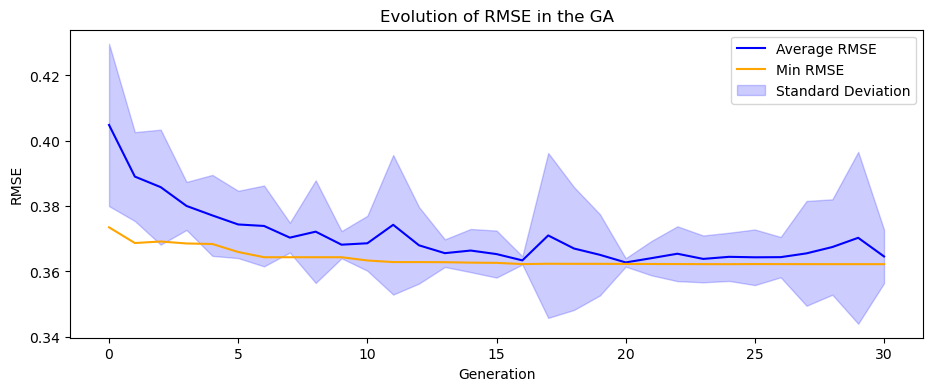

In [41]:
# Assuming logbook is already defined and populated
gen = np.array(logbook.select("gen"))
avg_mse = np.array(logbook.select("avg"))
min_mse = np.array(logbook.select("min"))
std_mse = np.array(logbook.select("std"))

# Calculate the upper and lower bounds for the shaded area
upper_bound = avg_mse + std_mse
lower_bound = avg_mse - std_mse

# Plot the graph
plt.figure(figsize=(11, 4))
plt.title("Evolution of RMSE in the GA")
plt.plot(gen, avg_mse, label="Average RMSE", color="blue")
plt.plot(gen, min_mse, label="Min RMSE", color="orange")
plt.fill_between(gen, lower_bound, upper_bound, color='blue', alpha=0.2, label="Standard Deviation")
plt.xlabel("Generation")
plt.ylabel("RMSE")
plt.legend()
plt.show()


In [42]:
# Assuming 'hof' is your HallOfFame object
best_individual = hof[0]  # The best individual
best_weights = {name: weight for name, weight in zip(weights.keys(), best_individual)}
best_mse = best_individual.fitness.values[0]

print("Best MSE:", best_mse)
print("Best Weights:")
for name, weight in best_weights.items():
    print(f"{name}: {weight}")


Best MSE: 0.36222293021421714
Best Weights:
traffic_weight: 0
fastFoods_weight: 99.20985560973496
hotels_weight: 4.934690512757022
motorwayLinks_weight: 35.860793012108964
motorways_weight: 99.11150706397427
restaurants_weight: 66.90143264496447
shopSupermarkets_weight: 44.84368475683832


In [43]:
with open("weights_float.txt", "w") as file:
    for name, value in best_weights.items():
        file.write(f"{name} {float(value)}\n")


In [44]:
# Define the path to the compiled executable
executable_path = './gravityscore'

# The CSV file name to pass as an argument
csv_file_name = 'moterway.csv'

# Run the compiled C++ program with the CSV file name as an argument
result = subprocess.run([executable_path, csv_file_name], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

# Process the result
if result.returncode == 0:
    print("C++ program output:\n", result.stdout)
else:
    print("Error running C++ program:\n", result.stderr)


C++ program output:
 Time taken: 569 milliseconds



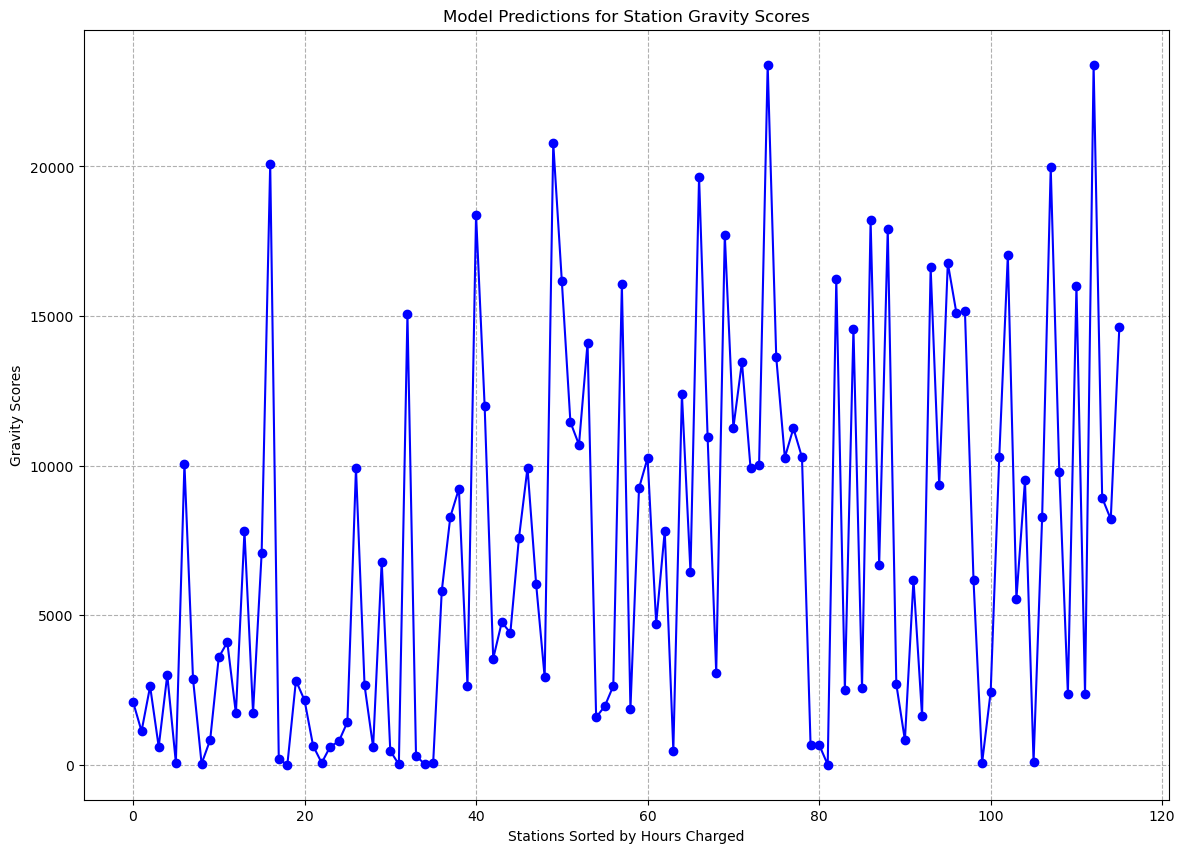

In [45]:
df_gravity = pd.read_csv('gravityScoresWithDetails.csv')
#change all gravity that a negative to zero
df_gravity['gravity'] = df_gravity['gravity'].apply(lambda x: 0 if x < 0 else x)

#plot df_gravity where x asis the the index and y axis the gravity
plt.figure(figsize=(14, 10))
plt.plot(df_gravity.index, df_gravity['gravity'], marker='o', linestyle='-', color='blue')
plt.xlabel('Stations Sorted by Hours Charged')
plt.ylabel('Gravity Scores')
plt.title('Model Predictions for Station Gravity Scores')
plt.grid(True, which="both", ls="--")
plt.show()

Mean Squared Error (MSE) on scaled data: 0.120450583116393
Root Mean Squared Error (RMSE) on scaled data: 0.3470599128628845


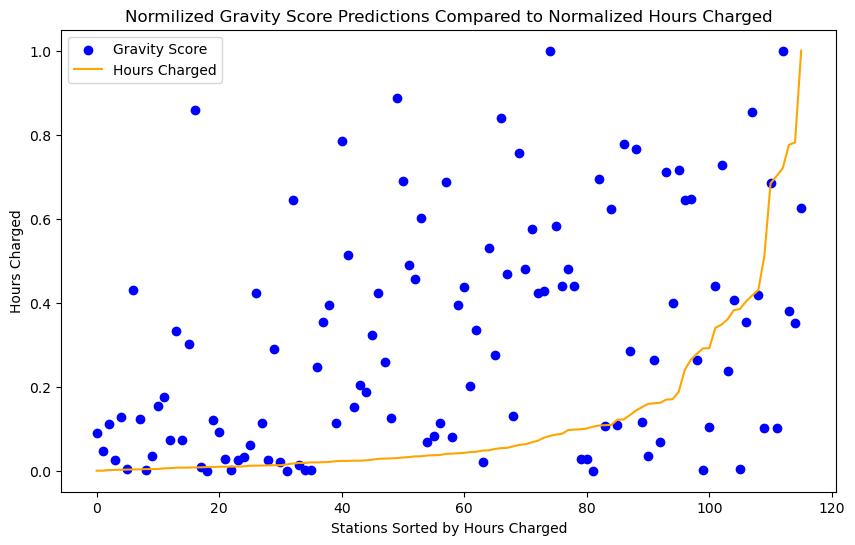

Mean Squared Error (MSE) on scaled data: 0.13120545117297364
Root Mean Squared Error (RMSE) on scaled data: 0.36222293021421714


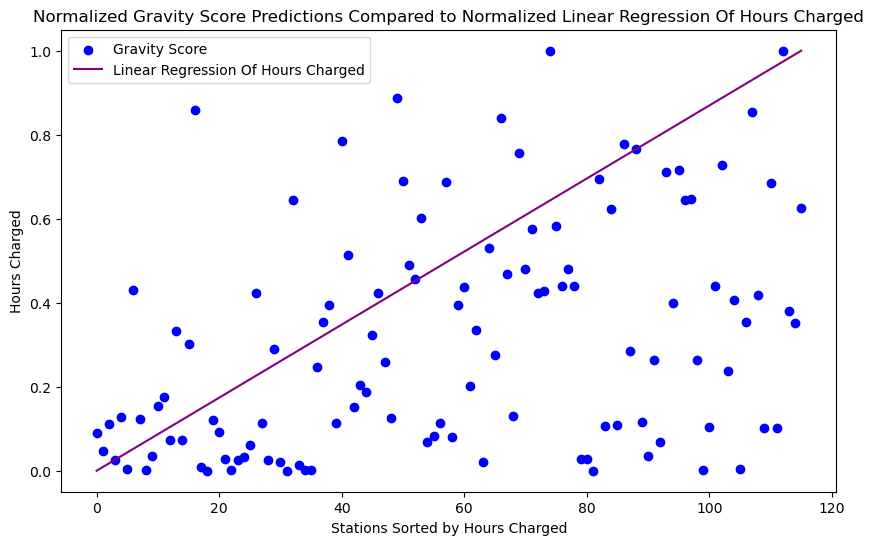

In [46]:
X = np.arange(len(df_moterway)).reshape(-1, 1)  # Element numbers as X
y = df_gravity['gravity'].values.reshape(-1, 1)
#y_original = df_moterway['status_3_ratio_mean'].values.reshape(-1, 1)  # status_3_ratio_mean as Y, reshaped for scaler


scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_gravity_scaled = scaler_y.fit_transform(y)


# Calculate MSE on the scaled predictions
mse_scaled = mean_squared_error(y_gravity_scaled, y_scaled)
rmse = np.sqrt(mse_scaled)

mse = mean_squared_error(y, y_original)

print(f"Mean Squared Error (MSE) on scaled data: {mse_scaled}")
print(f"Root Mean Squared Error (RMSE) on scaled data: {rmse}")


# Plotting the results (optional)
plt.figure(figsize=(10, 6))
plt.scatter(X, y_gravity_scaled, color='blue', label='Gravity Score')
plt.plot(X, y_scaled, color='orange', label='Hours Charged')
plt.title('Normilized Gravity Score Predictions Compared to Normalized Hours Charged')
plt.xlabel('Stations Sorted by Hours Charged')
plt.ylabel('Hours Charged')
plt.legend()
plt.show()


# Calculate MSE on the scaled predictions
mse_scaled = mean_squared_error(y_gravity_scaled, y_scaled_lin)
rmse = np.sqrt(mse_scaled)

# If you want to calculate MSE on the original scale
mse = mean_squared_error(y, y_original)

print(f"Mean Squared Error (MSE) on scaled data: {mse_scaled}")
print(f"Root Mean Squared Error (RMSE) on scaled data: {rmse}")

# Plotting the results (optional)
plt.figure(figsize=(10, 6))
plt.scatter(X, y_gravity_scaled, color='blue', label='Gravity Score')
plt.plot(X, y_scaled_lin, color='purple', label='Linear Regression Of Hours Charged')
plt.title('Normalized Gravity Score Predictions Compared to Normalized Linear Regression Of Hours Charged')
plt.xlabel('Stations Sorted by Hours Charged')
plt.ylabel('Hours Charged')
plt.legend()
plt.show()


C++ program output:
 Time taken: 609 milliseconds



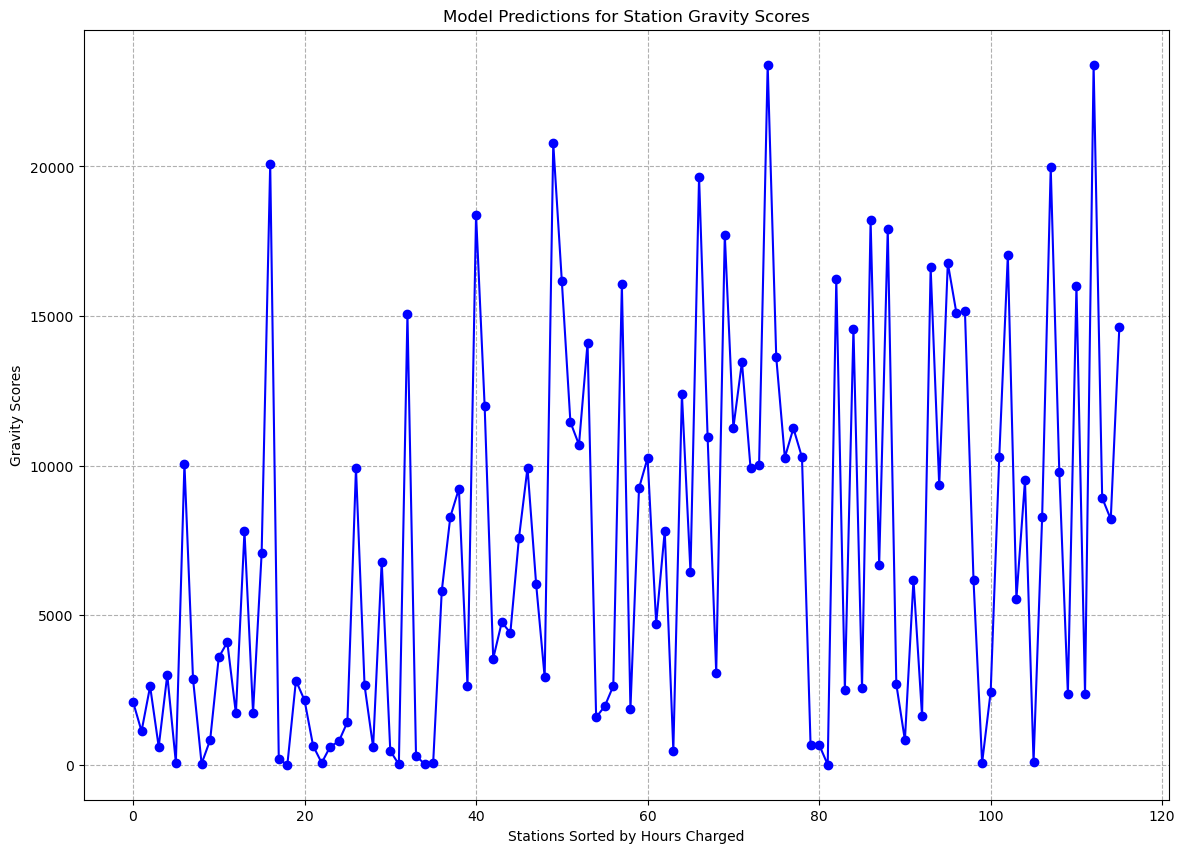

Mean Squared Error (MSE) on scaled data: 0.120450583116393
Root Mean Squared Error (RMSE) on scaled data: 0.3470599128628845


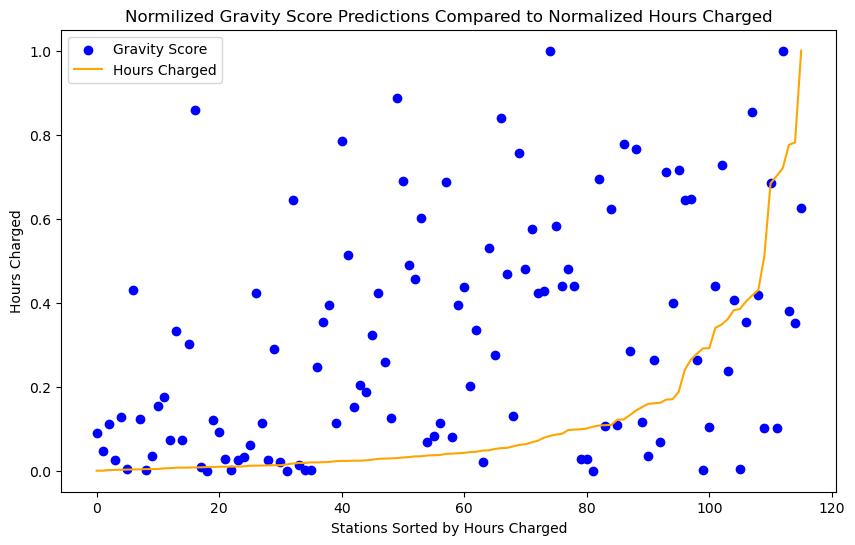

Mean Squared Error (MSE) on scaled data: 0.13120545117297364
Root Mean Squared Error (RMSE) on scaled data: 0.36222293021421714


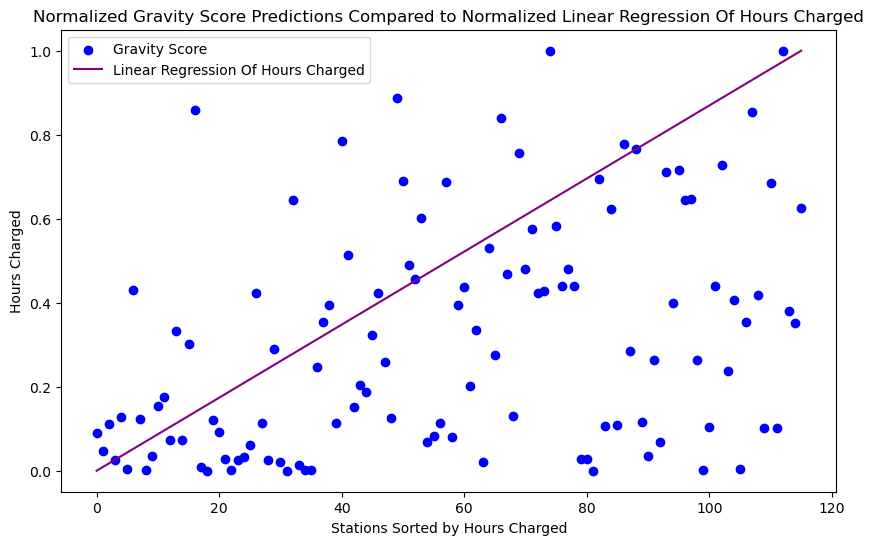

In [21]:

weights = { 
'traffic_weight': 0,
'fastFoods_weight': 99.20985560973496,
'hotels_weight': 4.934690512757022,
'motorwayLinks_weight': 35.860793012108964,
'motorways_weight': 99.11150706397427,
'restaurants_weight': 66.90143264496447,
'shopSupermarkets_weight': 44.84368475683832,
}
"""
fastFoods_weight: 99.20985560973496
hotels_weight: 4.934690512757022
motorwayLinks_weight: 35.860793012108964
motorways_weight: 99.11150706397427
restaurants_weight: 66.90143264496447
shopSupermarkets_weight: 44.84368475683832
weights = {

    "traffic_weight": 21.72581344219386,
    "fastFoods_weight": 48.39326966159999,
    "hospitals_weight": 37.47325144231801,
    "hotels_weight": 0.23891534441366727,
    "motorwayLinks_weight": 13.501116919389391,
    "motorways_weight": 281.03436948936263,
    "restaurants_weight": 61.2277085727219,
    "shopSupermarkets_weight": 11.679492237089558,
}
"""

with open("weights_float.txt", "w") as file:
    for name, value in weights.items():
        file.write(f"{name} {float(value)}\n")


# Define the path to the compiled executable
executable_path = './gravityscore'

# The CSV file name to pass as an argument
csv_file_name = 'moterway.csv'

# Run the compiled C++ program with the CSV file name as an argument
result = subprocess.run([executable_path, csv_file_name], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

# Process the result
if result.returncode == 0:
    print("C++ program output:\n", result.stdout)
else:
    print("Error running C++ program:\n", result.stderr)

df_gravity = pd.read_csv('gravityScoresWithDetails.csv')
#change all gravity that a negative to zero
df_gravity['gravity'] = df_gravity['gravity'].apply(lambda x: 0 if x < 0 else x)

#plot df_gravity where x asis the the index and y axis the gravity
plt.figure(figsize=(14, 10))
plt.plot(df_gravity.index, df_gravity['gravity'], marker='o', linestyle='-', color='blue')
plt.xlabel('Stations Sorted by Hours Charged')
plt.ylabel('Gravity Scores')
plt.title('Model Predictions for Station Gravity Scores')
plt.grid(True, which="both", ls="--")
plt.show()

X = np.arange(len(df_moterway)).reshape(-1, 1)  # Element numbers as X
y = df_gravity['gravity'].values.reshape(-1, 1)
#y_original = df_moterway['status_3_ratio_mean'].values.reshape(-1, 1)  # status_3_ratio_mean as Y, reshaped for scaler


scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_gravity_scaled = scaler_y.fit_transform(y)


# Calculate MSE on the scaled predictions
mse_scaled = mean_squared_error(y_gravity_scaled, y_scaled)
rmse = np.sqrt(mse_scaled)

mse = mean_squared_error(y, y_original)

print(f"Mean Squared Error (MSE) on scaled data: {mse_scaled}")
print(f"Root Mean Squared Error (RMSE) on scaled data: {rmse}")


# Plotting the results (optional)
plt.figure(figsize=(10, 6))
plt.scatter(X, y_gravity_scaled, color='blue', label='Gravity Score')
plt.plot(X, y_scaled, color='orange', label='Hours Charged')
plt.title('Normilized Gravity Score Predictions Compared to Normalized Hours Charged')
plt.xlabel('Stations Sorted by Hours Charged')
plt.ylabel('Hours Charged')
plt.legend()
plt.show()


# Calculate MSE on the scaled predictions
mse_scaled = mean_squared_error(y_gravity_scaled, y_scaled_lin)
rmse = np.sqrt(mse_scaled)

# If you want to calculate MSE on the original scale
mse = mean_squared_error(y, y_original)

print(f"Mean Squared Error (MSE) on scaled data: {mse_scaled}")
print(f"Root Mean Squared Error (RMSE) on scaled data: {rmse}")

# Plotting the results (optional)
plt.figure(figsize=(10, 6))
plt.scatter(X, y_gravity_scaled, color='blue', label='Gravity Score')
plt.plot(X, y_scaled_lin, color='purple', label='Linear Regression Of Hours Charged')
plt.title('Normalized Gravity Score Predictions Compared to Normalized Linear Regression Of Hours Charged')
plt.xlabel('Stations Sorted by Hours Charged')
plt.ylabel('Hours Charged')
plt.legend()
plt.show()



In [22]:
weights_all_names= {
    "traffic_weight": 0,
    "fastFoods_weight": 0,
    "hotels_weight": 0,
    "motorwayLinks_weight": 0,
    "motorways_weight": 0,
    "restaurants_weight": 0,
    "shopSupermarkets_weight": 0,
    "sportsCentres_weight": 0,
}

df_gravity = pd.read_csv('gravityScoresWithDetails.csv')
#change all gravity that a negative to zero
df_gravity['gravity'] = df_gravity['gravity'].apply(lambda x: 0 if x < 0 else x)

# Extracting names and removing '_weight' suffix
new_names = [name.replace('_weight', '') for name in weights_all_names.keys()]

# Generating new column names for df_gravity
# This includes keeping the original names for columns not being replaced
new_column_names = df_gravity.columns[:3].tolist() + new_names[:len(df_gravity.columns) - 3]

# Renaming the columns in df_gravity
df_gravity.columns = new_column_names

display(df_gravity)

#display the sum of each column
display(df_gravity.sum())

# Reset the index without changing the order of data
df_moterway.reset_index(drop=True, inplace=True)

display(df_moterway[['latitude', 'longitude','ratios_length', 'minCapacity', 'maxCapacity']])
df_gravity.to_csv('gravityScoresWithDetails.csv')

#add the collums ratios_length,minCapacity,maxCapacity from df_moterway to df_gravity on the same index
df_gravity['ratios_length'] = df_moterway['ratios_length']
df_gravity['minCapacity'] = df_moterway['minCapacity']
df_gravity['maxCapacity'] = df_moterway['maxCapacity']
df_gravity['slug'] = df_moterway['slug']
df_gravity['use'] = df_moterway['status_3_ratio_mean']

#make use only have two numbers after the point
df_gravity['use'] = df_gravity['use'].apply(lambda x: round(x, 2))

display(df_gravity[['latitude', 'longitude', 'gravity', 'use', 'ratios_length', 'minCapacity', 'maxCapacity', 'slug']])
df_gravity.to_csv('motormayTest.csv')

,longitude,latitude,gravity,traffic,fastFoods,hotels,motorwayLinks,motorways,restaurants,shopSupermarkets
0,10.16120,57.1524,2120.270,0,0.00,0.0,1458.550,661.721,0.0,0.000
1,9.36722,55.0655,1129.360,0,0.00,0.0,892.911,236.453,0.0,0.000
2,9.76432,56.1476,2627.190,0,0.00,0.0,1259.320,1367.870,0.0,0.000
3,9.93721,57.2226,608.926,0,0.00,0.0,0.000,608.926,0.0,0.000
4,9.76695,56.1497,3011.120,0,0.00,0.0,1861.930,1149.190,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...
111,11.36180,55.3879,2366.850,0,0.00,0.0,1019.460,1347.390,0.0,0.000
112,9.71694,55.5345,23396.100,0,14089.70,0.0,8047.610,328.884,0.0,929.919
113,10.41980,55.3527,8925.120,0,6652.86,0.0,1783.930,488.341,0.0,0.000
114,12.16140,55.4893,8212.990,0,5149.03,0.0,2474.910,589.054,0.0,0.000


longitude             1221.20487
latitude              6469.83680
gravity             853094.17276
traffic                  0.00000
fastFoods           462642.13000
hotels                1184.56100
motorwayLinks       195814.73500
motorways            99640.92400
restaurants          33083.69000
shopSupermarkets     60728.34900
dtype: float64

,latitude,longitude,ratios_length,minCapacity,maxCapacity
0,57.152389,10.161239,2,43.0,50.0
1,55.065492,9.367220,2,43.0,50.0
2,56.147603,9.764320,2,43.0,50.0
3,57.222600,9.937210,2,43.0,50.0
4,56.149722,9.766954,2,43.0,50.0
...,...,...,...,...,...
111,55.387910,11.361842,26,150.0,250.0
112,55.534483,9.716938,24,250.0,250.0
113,55.352714,10.419778,28,300.0,300.0
114,55.489341,12.161393,16,300.0,300.0


,latitude,longitude,gravity,use,ratios_length,minCapacity,maxCapacity,slug
0,57.1524,10.16120,2120.270,0.88,2,43.0,50.0,x697j
1,55.0655,9.36722,1129.360,0.89,2,43.0,50.0,ee8gk8
2,56.1476,9.76432,2627.190,1.18,2,43.0,50.0,eq7ry
3,57.2226,9.93721,608.926,1.24,2,43.0,50.0,z657z
4,56.1497,9.76695,3011.120,1.28,2,43.0,50.0,y6d79
...,...,...,...,...,...,...,...,...
111,55.3879,11.36180,2366.850,125.19,26,150.0,250.0,8zdpp
112,55.5345,9.71694,23396.100,128.49,24,250.0,250.0,rpnyj2
113,55.3527,10.41980,8925.120,138.28,28,300.0,300.0,nzn6mp
114,55.4893,12.16140,8212.990,139.30,16,300.0,300.0,qk7jyq
